1. Data Loading & Preprocessing  
Data preparation - Load dataset, handle missing values, extract time features for pattern analysis. Hourly resampling ensures consistent time intervals.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [11]:
df = pd.read_csv('AEP_hourly.csv', parse_dates=['Datetime'])
df.set_index('Datetime', inplace=True)
df = df.resample('H').mean().fillna(method='ffill')
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['consumption'] = df['AEP_MW']

2. Time Series Analysis   
Pattern visualization - Analyze daily, weekly, and hourly consumption patterns to identify peak periods and seasonal trends.

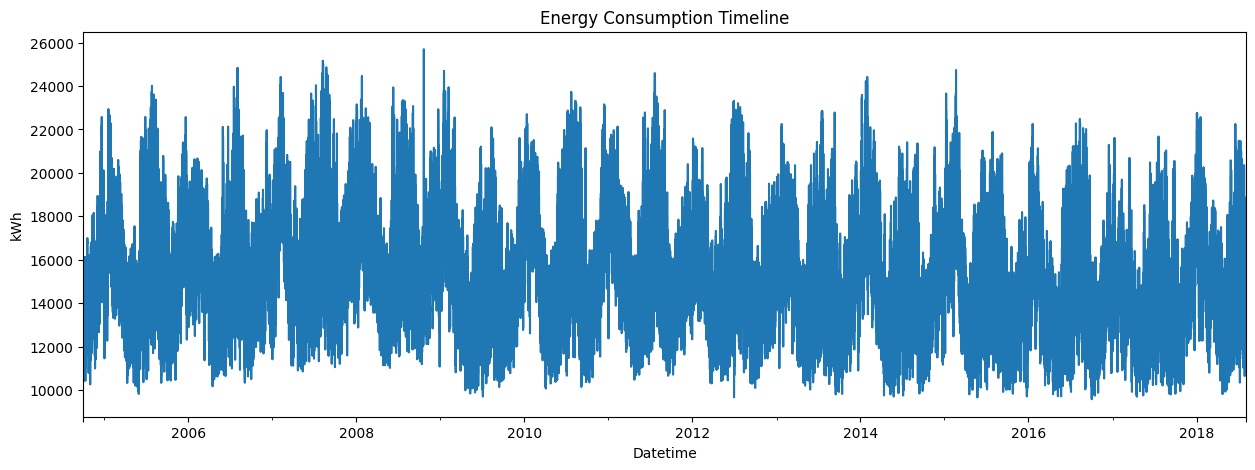

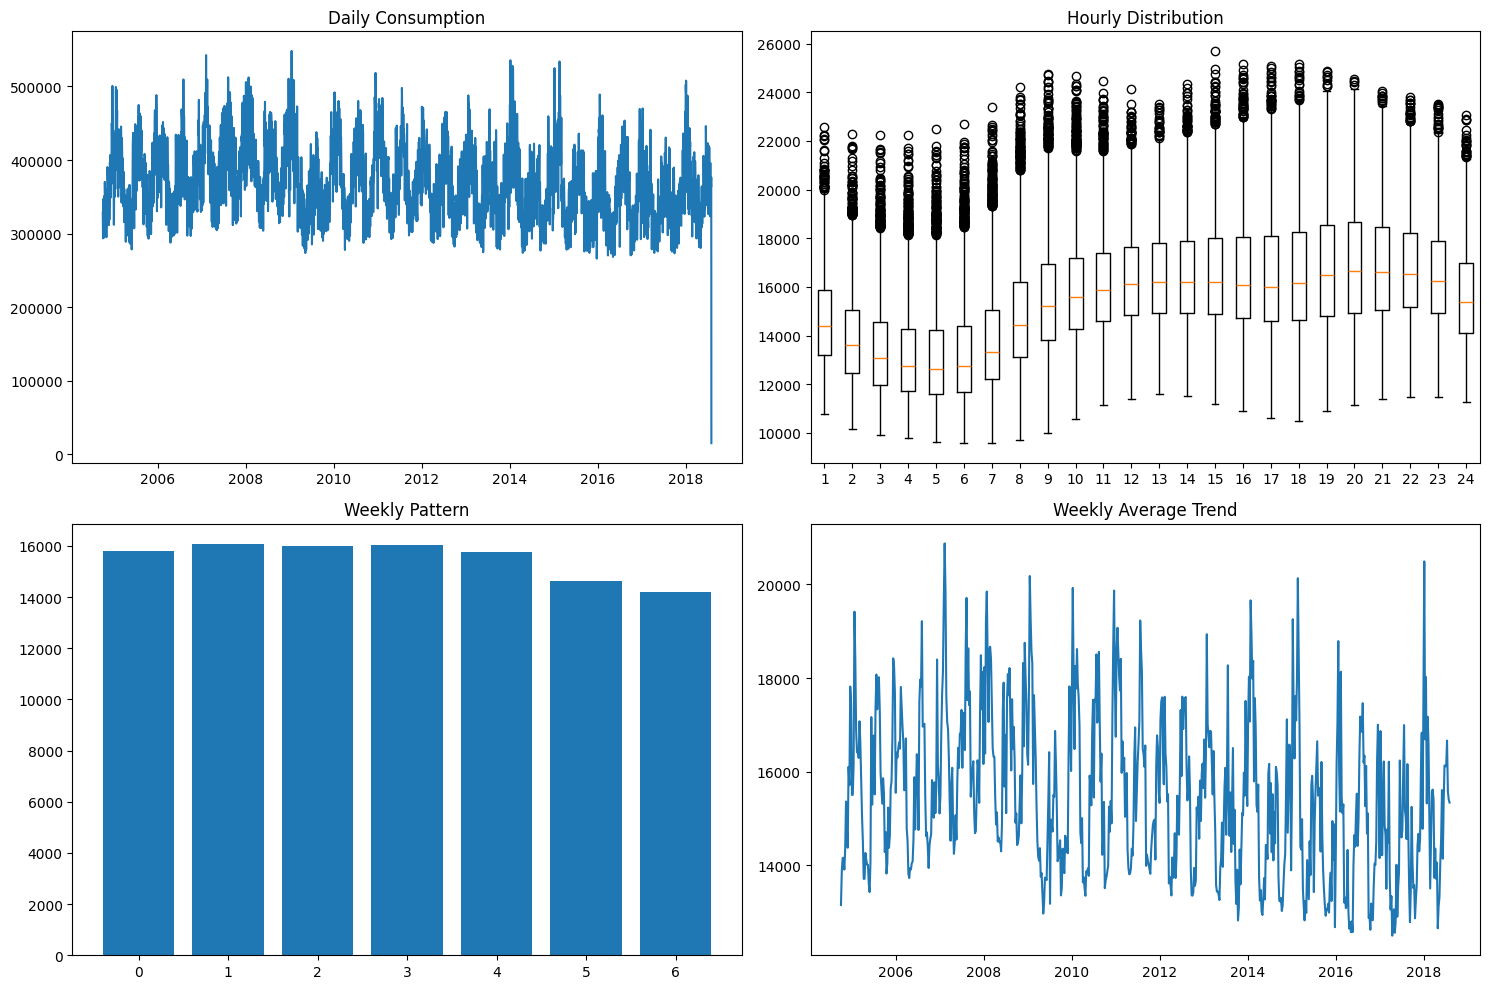

In [12]:
plt.figure(figsize=(15,5))
df['consumption'].plot(title='Energy Consumption Timeline')
plt.ylabel('kWh')
plt.show()

daily = df.resample('D').sum()
weekly = df.resample('W').mean()

fig, axes = plt.subplots(2,2,figsize=(15,10))
axes[0,0].plot(daily.index, daily['consumption'])
axes[0,0].set_title('Daily Consumption')
axes[0,1].boxplot([df[df['hour']==h]['consumption'] for h in range(24)])
axes[0,1].set_title('Hourly Distribution')
axes[1,0].bar(range(7), [df[df['day_of_week']==d]['consumption'].mean() for d in range(7)])
axes[1,0].set_title('Weekly Pattern')
axes[1,1].plot(weekly.index, weekly['consumption'])
axes[1,1].set_title('Weekly Average Trend')
plt.tight_layout()
plt.show()

3. Peak Detection & Anomalies  
Anomaly detection - Identify unusual consumption patterns using rolling statistics and z-score analysis for operational insights.

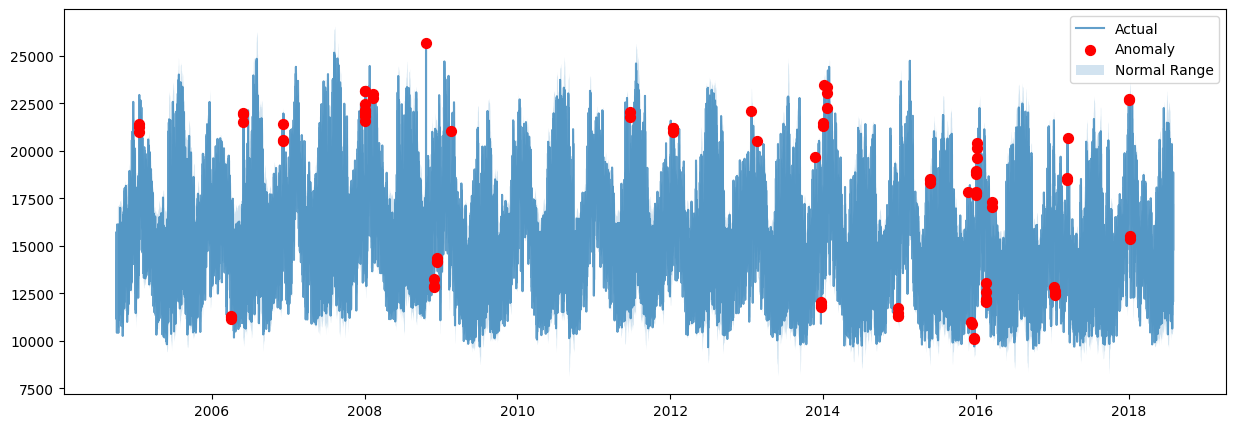

In [13]:
df['rolling_avg'] = df['consumption'].rolling(window=24*7).mean()
df['rolling_std'] = df['consumption'].rolling(window=24*7).std()
df['z_score'] = (df['consumption'] - df['rolling_avg']) / df['rolling_std']
df['anomaly'] = df['z_score'].abs() > 3

plt.figure(figsize=(15,5))
plt.plot(df.index, df['consumption'], label='Actual', alpha=0.7)
plt.scatter(df[df['anomaly']].index, df[df['anomaly']]['consumption'], 
            color='red', s=50, label='Anomaly', zorder=5)
plt.fill_between(df.index, 
                 df['rolling_avg'] - 2*df['rolling_std'], 
                 df['rolling_avg'] + 2*df['rolling_std'], 
                 alpha=0.2, label='Normal Range')
plt.legend()
plt.show()

In [16]:
df.dropna(inplace=True)

4. Daily Pattern Clustering  
Consumption profiling - Cluster days into 3 behavioral patterns (weekday/weekend/special) using normalized hourly profiles.

In [17]:
daily_profiles = df.groupby([df.index.date, 'hour'])['consumption'].mean().unstack()
scaler = StandardScaler()
scaled_profiles = scaler.fit_transform(daily_profiles.T).T

kmeans = KMeans(n_clusters=3, random_state=42)
daily_profiles['cluster'] = kmeans.fit_predict(scaled_profiles)

plt.figure(figsize=(12,6))
for cluster in range(3):
    cluster_data = daily_profiles[daily_profiles['cluster']==cluster].iloc[:,:24].mean()
    plt.plot(range(24), cluster_data, label=f'Cluster {cluster}', linewidth=3)
plt.xlabel('Hour')
plt.ylabel('Normalized Consumption')
plt.legend()
plt.show()

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values